<a href="https://colab.research.google.com/github/blandersonw/KarpathyNeuralNetworks/blob/main/MicroGrad_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2-4*x+5

In [3]:
f(3.0)

20.0

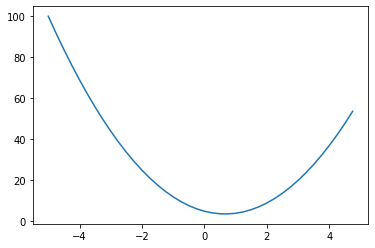

In [4]:
xs = np.arange(-5,5,.25)
ys = f(xs)

plt.plot(xs,ys)

In [5]:
#definition of the derivative
h= 0.0001
x = 2/3
(f(x+h)-f(x))/h

0.0002999999981767587

In [6]:
#product rule next
a = 2.0
b = -3.0
c = 10.0

d = a*b+c

print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
#dd/da: a += h -> -3
#dd/db: b += h -> 2
#dd/dc: b += h -> 1
#THINK COEFFICIENT HERE
d2 = a*b+c
(d2-d1)/h

0.0

In [24]:
class Value:

  def __init__(self, data, _children=(), _op='', label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  #repr just formats our output
  def __repr__(self):
    return(f"Value(data={self.data})")
  
  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data, (self,other), '+')
      
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    
    out._backward = _backward
    
    return out 
  
  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward

    return out 
  
  def __pow__(self,other):
    assert isinstance(other, (int,float))
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    
    out._backward = _backward

    return out

  def __rmul__(self,other):
    return self*other
  
  def __truediv__(self,other):
    return self*other**-1
  
  def __neg__(self):
    return self*-1
  
  def __sub__(self,other):
    return(self + (-other))

  def __radd__(self,other):
    return self+other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1- t**2) * out.grad

    out._backward = _backward

    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
  
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label='L'


In [9]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [10]:
d._op

'+'

In [11]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return(nodes,edges)

def draw_dot(root):
  dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))

    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op,uid)
    
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  
  return dot


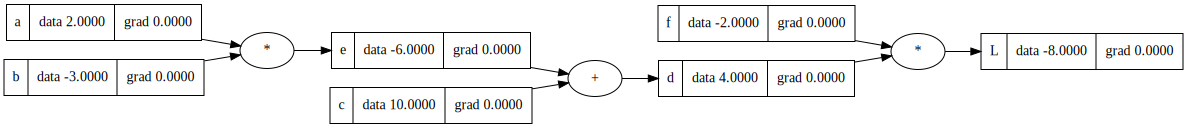

In [12]:
draw_dot(L)
#Visualizing FORWARD pass

In [13]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0
b.grad = -4.0


In [14]:
a.data += .01 * a.grad
b.data += .01 * b.grad
c.data += .01 * c.grad
f.data += .01 * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-7.286496


In [15]:
"""
MOST IMPORTANT PART OF BACK PROPOGATION
dd / dc = ??
d = c+e ===> dd/dc = 1.0'

dL / dc = (dL / dd) * (dd/dc)
dL / dc = (-2.0) * (1.0)

dL / da = ??
dL / da = (dL/dc) * (dc / da)
= -2.0 * -3.0 = 6.0
"""

"\nMOST IMPORTANT PART OF BACK PROPOGATION\ndd / dc = ??\nd = c+e ===> dd/dc = 1.0'\n\ndL / dc = (dL / dd) * (dd/dc)\ndL / dc = (-2.0) * (1.0)\n\ndL / da = ??\ndL / da = (dL/dc) * (dc / da)\n= -2.0 * -3.0 = 6.0\n"

In [16]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label='e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d*f; L.label='L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label='e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d*f; L.label='L'
  L2 = L.data
  print((L2-L1)/h)

lol()

0.0


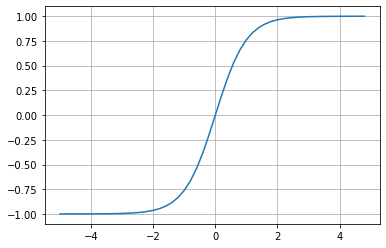

In [17]:
plt.plot(np.arange(-5,5,.2), np.tanh(np.arange(-5,5,.2)))
plt.grid()

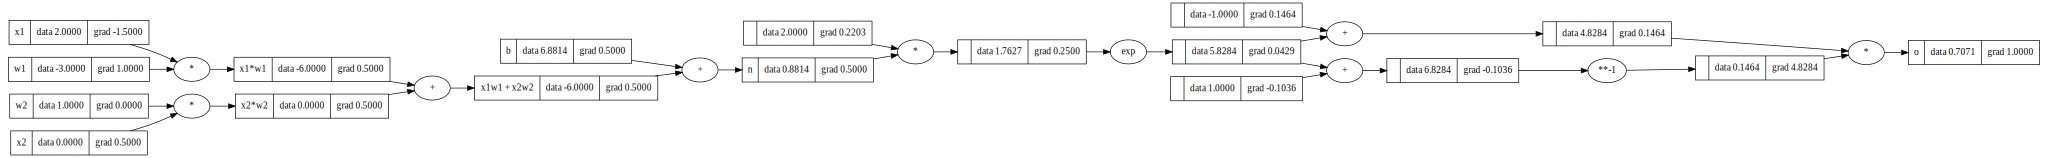

In [25]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2+b; n.label='n'

e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)

In [19]:
"""
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
"""

'\no.grad = 1.0\no._backward()\nn._backward()\nx1w1x2w2._backward()\nx1w1._backward()\nx2w2._backward()\n'

In [20]:
"""
# o = tanh(n)
# do/dn = 
n.grad = (1-o.data**2)

x1w1x2w2.grad = n.grad
x1w1.grad, x2w2.grad = n.grad, n.grad
"""

'\n# o = tanh(n)\n# do/dn = \nn.grad = (1-o.data**2)\n\nx1w1x2w2.grad = n.grad\nx1w1.grad, x2w2.grad = n.grad, n.grad\n'

In [21]:
"""x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad"""

'x1.grad = w1.data * x1w1.grad\nw1.grad = x1.data * x1w1.grad\n\nx2.grad = w2.data * x2w2.grad\nw2.grad = x2.data * x2w2.grad'

In [22]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a*b ; d.label = 'd'
e = a+b ; e.label = 'e'
f = d*e ; f.label = 'f'
f.backward()

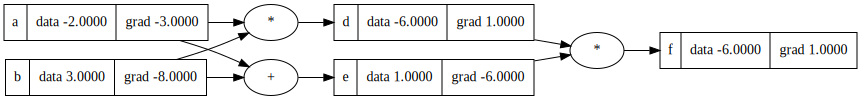

In [23]:
draw_dot(f)